# IY011 Contrastive Learning Model Training (Part 2)

```Python
# === APPROACH 2: SIAMESE NETWORK (Metric Learning) ===

def siamese_pipeline(all_files):
    # --- PHASE 1: DATA PREPARATION ---
    
    # 1. Split FILES (Zero Leakage) - Train, Validation, Test
    # We split by File ID, not sample ID. 
    # "File A" is strictly in Train. "File Z" is strictly in Test.
    # The model cannot memorize "File Z" because it never sees it during training.
    train_files, test_files = split_files(all_files, test_size=0.2)
    train_files, val_files = split_files(train_files, test_size=0.2)

    # 2. Generate Dynamic Pairs (Infinite Data)
    # We generate ~20,000 unique pairs (1 vs 1) of data from a data pool of 1024 files (each containing 1000 x 1811 timepoints).
    # Positive Pair: (Crop 200 timepoints from File A, Different Crop from File A)
    # Negative Pair: (Crop 200 timepoints from File A, Crop 200 timepoints from File B)
    train_groups = build_pairs(train_files, num_pairs=20000)

    # 3. Log-Linear Preprocessing
    # This is necessary because the mean of the synthetic data ranges from 1 to 10_000 
    # (global mean ~= 5000), so low-mean signals are "invisible" to the model if we 
    # simply use Linear scaling.
    # Log-transform expands the range of low-mean signals so the model can "see" them. 
    # Standard scaling normalises them for the neural net.
    train_groups = log1p(train_groups) 
    scaler.fit(train_groups) 
    train_ds = RandomCropDataset(train_groups, crop_len=200)

    # --- PHASE 2: MODEL TRAINING ---

    # 4. Architecture: Siamese Wrapper
    backbone = TransformerBackbone() # The shared "Physics Engine"
    
    for x1, x2, label in train_loader:
        # A. Extract Features (Shared Weights)
        z1 = backbone(x1) # Feature Vector 1
        z2 = backbone(x2) # Feature Vector 2

        # B. Inductive Bias (The "Difference" Head)
        # We explicitly feed the absolute difference to the classifier.
        # This forces the model to measure "Distance" (temporal differences - e.g., autocorrelation, burst patterns), 
        # not "Identity" (mean, variance).
        # In the future, we'll use contrastive loss functions e.g. InfoNCE, 
        # Triplet Loss instead so we can avoid this manual feature engineering step.
        features = concatenate(z1, z2, abs(z1 - z2))
        
        # C. Objective: Similarity
        # Label 1 = Same Source, Label 0 = Different Source
        # WHY DO WE NEED A CLASSIFIER HEAD HERE?
        # Because we need this to calculate the loss during training, even though we will discard it later.
        similarity_score = classifier_head(features) 
        loss = BCEWithLogitsLoss(similarity_score, label) # we'll use contrastive loss in future
        # Backpropagation
        loss.backward()

    # --- PHASE 3: DEPLOYMENT (Inference) ---
    
    # 5. Deployment
    # We discard the 'classifier_head' and keep only the 'backbone'.
    feature_extractor = backbone.eval()

    return feature_extractor

# EXPLANATION : Why isn't this redundant? (Why not train a classifier directly?)
    
    1. The Trap: A standard classifier trained on synthetic files effectively "cheats." 
       It memorizes static shortcuts—like "Mean Intensity = 500 usually means File #12." 
       Real biological data has totally different intensity/noise profiles, so those 
       shortcuts break immediately (the "Reality Gap").
    
    2. The Solution: The Siamese task forces the model to ignore those static values.
       By comparing random crops, it learns that "burst shape" is the only reliable 
       feature that stays constant. This "physics" (bursting) is the only thing 
       truly shared between our simulations and the real cells.
    
    3. The Bridge: The model now speaks "Physics", but we need "Biology".
       The Reference Library bridges that gap—it's just a lookup table that says:
       "This specific type of bursting behavior corresponds to Wild Type."

# 1. Why do we use Log Transformation?

We use `np.log1p` because biological intensity data often follows a **power-law or exponential distribution**.

## The Problem (Linear Scaling)

Your mean intensity \( \mu \) ranges from **1 to 10,000**.  
A standard scaler computes a global mean of roughly **5000**.

A trajectory with \( \mu = 10 \):

\[
\frac{10 - 5000}{\sigma} \approx -1.99
\]

A trajectory with \( \mu = 50 \):

\[
\frac{50 - 5000}{\sigma} \approx -1.98
\]

**Result:**  
To the neural network, these values are almost identical.  
The biologically important **low-signal dynamics** get compressed into numerical noise.  
The model becomes blind to ~50% of your dataset.

## The Solution (Log Scaling)

\[
\ln(10) \approx 2.3
\]
\[
\ln(50) \approx 3.9
\]

**Result:**  
Low and medium intensities separate cleanly.  
The model can “see” differences in burst amplitudes and patterns.

---

# 2. How does *Training on Pairs* allow *Classifying Singles*?

This is the **Feature Extractor** strategy — the same idea behind Face ID systems.

## Training Phase (Pairs)

You train the model on pairs \((x_1, x_2)\) asking:

**“Are these the same?”**

To solve this, the model learns to measure:
- intensity trends  
- burst frequency  
- dynamic similarity  

It learns to ignore things like:
- noise level  
- baseline offset  
- absolute amplitude  

It becomes a **“time-series → embedding” converter** (the Backbone).

## Deployment Phase (Singles)

Now you give the model **a single trajectory**.

You pass it through the Backbone → it outputs an embedding:

\[
[0.5,\; 0.1,\; 0.9,\; ...]
\]

This is a compact representation of the trajectory’s **physics**.

## Classification (Reference Library)

You compare this embedding with a small library of embeddings representing known classes.

> “Is this closer to Class A or Class B?”

This lets you classify **single** time series using the physics learned during **pairwise** training.

---

# 3. Why isn’t this redundant?

You asked: *“Why not just train a classifier directly?”*

Because **direct classifiers cheat**.

## Direct Classifier (The Memorizer)

If you train on “Synthetic File 1 vs Synthetic File 2”, the model exploits metadata:

- different background noise  
- different preprocessing  
- different trajectory lengths  

When you feed real data, this metadata changes → the model collapses.

It learned **file ID**, not **biological dynamics**.

## Siamese Model (The Physicist)

By training on **pairs**, you force the model to:

- ignore metadata  
- ignore absolute scale  
- focus on burst frequency, shape, timing, dynamics  

These features **transfer** from synthetic to real data.

The Siamese model becomes a **universal translator** from raw trajectories → physical properties.  
Classification is then just matching these properties to a reference.

---


In [2]:
import os
import subprocess
import glob
import tempfile
from pathlib import Path
import numpy as np
import pandas as pd
import time
# plotting 
import matplotlib.pyplot as plt
from visualisation.plots import plot_mRNA_dist, plot_mRNA_trajectory
# ml
import torch, itertools
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from models.siamese_transformer import SiameseTransformer
from training.eval import evaluate_model
from training.train import train_model 

# data handling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Build groups
from utils.data_processing import build_groups
# Load siamese data prep pipeline from modularised code
from utils.data_loader import SiameseGroupDataset, siamese_data_prep
import wandb

%load_ext autoreload
%autoreload 2  

In [3]:
DATA_ROOT = Path("/home/ianyang/stochastic_simulations/experiments/EXP-25-IY011/data")
RESULTS_PATH = DATA_ROOT / "IY011_simulation_parameters_sobol.csv" #  this csv file stores all the simulation parameters used
df_params = pd.read_csv(RESULTS_PATH) 
# TRAJ_PATH = [DATA_ROOT / f"mRNA_trajectories_mu{row['mu_target']:.3f}_cv{row['cv_target']:.3f}_tac{row['t_ac_target']:.3f}.csv" for idx, row in df_params.iterrows()] # the trajectories 
TRAJ_PATH = [DATA_ROOT / df_params['trajectory_filename'].values[i] for i in range(len(df_params))]
TRAJ_NPZ_PATH = [traj_file.with_suffix('.npz') for traj_file in TRAJ_PATH]

# extract meta data
parameter_sets = [{
    'sigma_b': row['sigma_b'],
    'sigma_u': row['sigma_u'],
    'rho': row['rho'],
    'd': row['d'],
    'label': 0
} for idx, row in df_params.iterrows()]
time_points = np.arange(0, 3000, 1.0)
size = 1000

In [10]:
# === Dataloader hyperparams & data prep ===
batch_size = 64
num_groups_train=20000  
num_groups_val=num_groups_train // 10
num_groups_test=num_groups_train // 10
num_traj=2
train_loader, val_loader, test_loader, scaler = siamese_data_prep(
    TRAJ_NPZ_PATH,
    batch_size=batch_size,
    num_groups_train=num_groups_train,
    num_groups_val=num_groups_val,
    num_groups_test=num_groups_test,
)
# === Dataloader hyperparams & data prep ===

Files split: 655 Train, 164 Val, 205 Test
Generating 20000 training pairs...


Building negative groups: 100%|██████████| 10000/10000 [00:00<00:00, 21152.69it/s]


Generating validation/test pairs...


Building negative groups: 100%|██████████| 1000/1000 [00:00<00:00, 21339.19it/s]


Building negative groups: 100%|██████████| 1000/1000 [00:00<00:00, 21493.16it/s]


Fitting scaler on Log-Transformed training data...
Applying Log-Scaling to all groups...


In [4]:
X1_b, X2_b, y_b = next(iter(train_loader))
print(X1_b.shape, X2_b.shape, y_b.shape)
# want: [B, T, 1], [B, T, 1], [B]

torch.Size([64, 200, 1]) torch.Size([64, 200, 1]) torch.Size([64, 1])


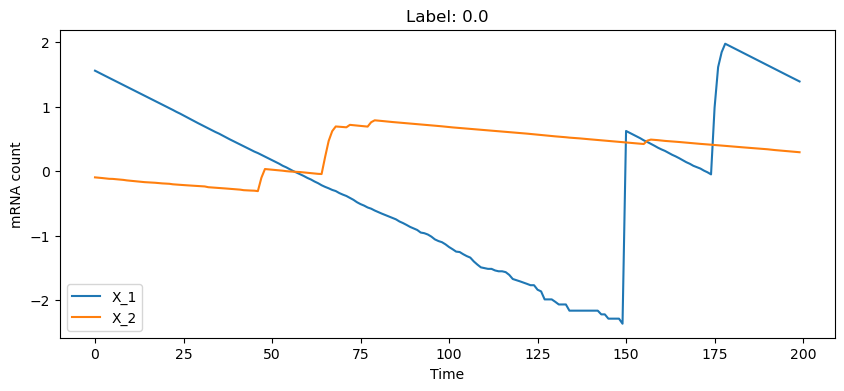

In [9]:
# plot the first pair in the batch
plt.figure(figsize=(10,4))
plt.plot(X1_b[0,:,0].numpy(), label='X_1')
plt.plot(X2_b[0,:,0].numpy(), label='X_2')
plt.title(f"Label: {y_b[0].item()}")
plt.xlabel("Time")
plt.ylabel("mRNA count")
plt.legend()
plt.show()

In [7]:
# === Model hyperparams ===
input_size = 1
num_classes = 2
d_model=64
nhead=4
num_layers=2
dropout=0.001
use_conv1d=False 

model = SiameseTransformer(
    input_size=input_size,   
    d_model=d_model,
    nhead=nhead,
    num_layers=num_layers,
    dropout=dropout,
    use_conv1d=use_conv1d,
)
# === Model hyperparams ===

# === Training hyperparams ===
epochs = 100
patience = 10
lr = 1e-2
optimizer = optim.Adam(model.parameters(), lr=lr)

### schedulers ### 
# 1. simple scheduler choice
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5) 

# 2. cosine scheduler with warmup, most commonly used for transformer
# total_steps = epochs * len(train_loader)
# warmup_steps = int(0.1 * total_steps)   # 10% warmup (good default)
#  (from huggingface)
# from transformers import get_cosine_schedule_with_warmup
# scheduler = get_cosine_schedule_with_warmup(
#     optimizer,
#     num_warmup_steps=warmup_steps,
#     num_training_steps=total_steps,
# ) 

loss_fn = nn.BCEWithLogitsLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
grad_clip = 1.0
save_path = None
verbose = True

model.to(device)
# === Training hyperparams ===

SiameseTransformer(
  (backbone): TransformerClassifier(
    (input_proj): Linear(in_features=1, out_features=64, bias=True)
    (pe): PositionalEncoding()
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
          )
          (linear1): Linear(in_features=64, out_features=256, bias=True)
          (dropout): Dropout(p=0.001, inplace=False)
          (linear2): Linear(in_features=256, out_features=64, bias=True)
          (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.001, inplace=False)
          (dropout2): Dropout(p=0.001, inplace=False)
        )
      )
    )
    (dropout): Dropout(p=0.001, inplace=False)
    (head): Linear(in_features=64, out_features=2, bias=True

In [7]:
# === wandb config (required for tracking within train_model) ===
wandb_config = {
    "entity": "grignard-reagent",
    "project": "IY011-contrastive-learning",
    "name": f"siamese_logtransform-feature-diff_num_train_groups_{num_groups_train}", # change this to what you want
    "dataset": DATA_ROOT.name,
    "batch_size": batch_size,
    "input_size": input_size,
    "d_model": d_model,
    "nhead": nhead,
    "num_layers": num_layers,
    "num_classes": num_classes,
    "dropout": dropout,
    "use_conv1d": use_conv1d,
    "epochs": epochs,
    "patience": patience,
    "lr": lr,
    "optimizer": type(optimizer).__name__,
    "scheduler": type(scheduler).__name__,
    "loss_fn": type(loss_fn).__name__,
    "model": type(model).__name__,
    "batch_size": train_loader.batch_size,
    "num_traj_per_group": num_traj,
    "num_groups_train": num_groups_train,
    "num_groups_val": num_groups_val,
    "num_groups_test": num_groups_test,
}
# === wandb config === 

In [8]:
from training.train import train_siamese_model
history = train_siamese_model(
    model,
    train_loader,
    val_loader,
    epochs=epochs,
    patience=patience,
    lr=lr,
    optimizer=optimizer,
    scheduler=scheduler,
    loss_fn=loss_fn,
    device=device,
    grad_clip=grad_clip,
    save_path=save_path,
    verbose=verbose,
    wandb_logging=True, # this enables wandb logging within train_model
    wandb_config=wandb_config, # pass the config dictionary
)

wandb: Currently logged in as: grignardreagent (grignard-reagent) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Starting siamese training...
[Siamese] Epoch [1/100] | train_loss 0.6416 | train_acc 0.6437 | val_loss 0.6256 | val_acc 0.6585
[Siamese] Epoch [2/100] | train_loss 0.6026 | train_acc 0.6724 | val_loss 0.6003 | val_acc 0.6720
[Siamese] Epoch [3/100] | train_loss 0.6004 | train_acc 0.6767 | val_loss 0.5853 | val_acc 0.6860
[Siamese] Epoch [4/100] | train_loss 0.5647 | train_acc 0.7050 | val_loss 0.5415 | val_acc 0.7330
[Siamese] Epoch [5/100] | train_loss 0.5544 | train_acc 0.7154 | val_loss 0.5056 | val_acc 0.7485
[Siamese] Epoch [6/100] | train_loss 0.4884 | train_acc 0.7590 | val_loss 0.4823 | val_acc 0.7600
No improvement (1/10).
[Siamese] Epoch [7/100] | train_loss 0.4626 | train_acc 0.7739 | val_loss 0.4905 | val_acc 0.7480
No improvement (2/10).
[Siamese] Epoch [8/100] | train_loss 0.4578 | train_acc 0.7734 | val_loss 0.5147 | val_acc 0.7545
[Siamese] Epoch [9/100] | train_loss 0.4508 | train_acc 0.7836 | val_loss 0.4484 | val_acc 0.7740
[Siamese] Epoch [10/100] | train_loss 0.412

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
grad/norm,▁██▆██████████▅████████████▃██▆████████
lr,████▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/acc,▁▂▂▃▃▄▅▅▅▆▆▆▆▇▇▇▇█▇▇███████████████████
train/loss,█▇▇▇▆▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/acc,▁▁▂▃▄▄▄▄▅▆▆▆▆▇▇▇▇▇█▇███████████████████
val/loss,█▇▇▆▅▅▅▆▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_val_acc,0.872
epoch,39
grad/norm,1.0
lr,2e-05


Siamese training complete.


## Save / Load Model

In [ ]:
# save the trained model
# siamese_model_path = "IY011_siamese_transformer_model.pth"
# torch.save(model.state_dict(), siamese_model_path)

In [8]:
# load the siamese model
model = SiameseTransformer(
    input_size=input_size,   
    d_model=d_model,
    nhead=nhead,
    num_layers=num_layers,
    dropout=dropout,
    use_conv1d=use_conv1d,
)
siamese_model_path = "IY011_siamese_transformer_model.pth"
model.load_state_dict(torch.load(siamese_model_path))
model.to(device)

SiameseTransformer(
  (backbone): TransformerClassifier(
    (input_proj): Linear(in_features=1, out_features=64, bias=True)
    (pe): PositionalEncoding()
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
          )
          (linear1): Linear(in_features=64, out_features=256, bias=True)
          (dropout): Dropout(p=0.001, inplace=False)
          (linear2): Linear(in_features=256, out_features=64, bias=True)
          (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.001, inplace=False)
          (dropout2): Dropout(p=0.001, inplace=False)
        )
      )
    )
    (dropout): Dropout(p=0.001, inplace=False)
    (head): Linear(in_features=64, out_features=2, bias=True

## Eval 

In [14]:
# === Evaluate on test set ===
model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for x1, x2, y in test_loader:
        x1, x2, y = x1.to(device), x2.to(device), y.to(device)
        
        # Forward pass (Siamese)
        logits = model(x1, x2)
        loss = loss_fn(logits, y)
        
        test_loss += loss.item() * y.size(0)
        
        # Accuracy: Logits > 0 implies Probability > 0.5 (Class 1)
        preds = (logits > 0).float()
        correct += (preds == y).sum().item()
        total += y.size(0)

test_loss /= len(test_loader.dataset)
test_acc = correct / total

print(f"Test — loss: {test_loss:.4f} | acc: {test_acc:.4f}")

Test — loss: 0.2319 | acc: 0.9060


In [15]:
# === Predict probabilities on test set ===
model.eval()
all_probs = []
all_targets = []

with torch.no_grad():
    for x1, x2, y in test_loader:
        x1, x2, y = x1.to(device), x2.to(device), y.to(device)

        logits = model(x1, x2)
        # Sigmoid to get probability (0, 1)
        probs = torch.sigmoid(logits)

        all_probs.append(probs.cpu())
        all_targets.append(y.cpu())

all_probs = torch.cat(all_probs)
all_targets = torch.cat(all_targets)

print(f"Sample probabilities: {all_probs[:10].flatten()}")

Sample probabilities: tensor([9.4586e-01, 7.3692e-18, 8.8431e-01, 9.2141e-01, 8.7646e-01, 2.6163e-06,
        1.7936e-04, 9.6754e-01, 9.8412e-01, 9.4698e-01])


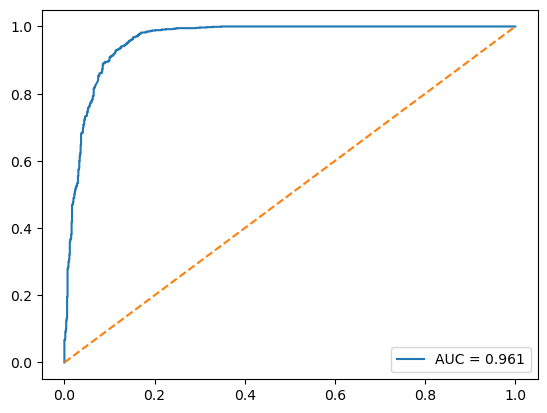

In [16]:
# === ROC AUC ===
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

probs = all_probs.numpy()
targets = all_targets.numpy()

fpr, tpr, _ = roc_curve(targets, probs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.legend()
plt.show()


## Test out model using unseen data (single trajectory inputs)

First, let's generate some unseen data using the julia pipeline

In [12]:
from simulation.mean_cv_t_ac import find_tilda_parameters
from simulation.julia_simulate_telegraph_model import simulate_telegraph_model

def generate_unseen_classes(n_classes=5, n_trajs_per_class=20, seq_len=3000):
    """
    Generates N new 'mystery' datasets with random parameters.
    Returns a list of dictionaries, each representing a unique biological condition.
    """
    print(f"Generating {n_classes} unseen classes...")
    unseen_data = []
    
    # Randomly sample parameters (Mu, CV, Tac)
    # We pick ranges similar to your training data to ensure they are valid biological possibilities
    mus = np.random.uniform(10, 1000, n_classes)
    cvs = np.random.uniform(0.5, 2.0, n_classes)
    tacs = np.random.uniform(5, 50, n_classes)
    
    time_points = np.arange(0, seq_len, 1.0)

    for i in range(n_classes):
        try:
            # 1. Solve for physical parameters
            rho, d, sigma_b, sigma_u = find_tilda_parameters(mus[i], tacs[i], cvs[i])
            
            # 2. Simulate
            params = [{"sigma_b": sigma_b, "sigma_u": sigma_u, "rho": rho, "d": d, "label": 0}]
            df = simulate_telegraph_model(params, time_points, n_trajs_per_class)
            
            # 3. Extract clean array (N_trajs, Time)
            # Assuming format: columns t_0...t_T, rows are trajectories
            # Adjust filtering based on your exact df structure
            trajs = df.drop(columns=['label'], errors='ignore').values
            
            unseen_data.append({
                "class_id": f"Mystery_Class_{i}",
                "parameters": {"mu": mus[i], "cv": cvs[i], "tac": tacs[i]},
                "trajectories": trajs
            })
            print(f"  Generated Class {i}: Mu={mus[i]:.1f}, CV={cvs[i]:.2f}")
            
        except Exception as e:
            print(f"  Skipped a class due to solver error: {e}")
            
    return unseen_data

# === RUN GENERATION ===
unseen_datasets = generate_unseen_classes(n_classes=5, n_trajs_per_class=20)

Generating 5 unseen classes...


/home/ianyang/micromamba/envs/stochastic_sim/lib/python3.11/site-packages/juliacall/__init__.py:61: UserWarning: torch was imported before juliacall. This may cause a segfault. To avoid this, import juliacall before importing torch. For updates, see https://github.com/pytorch/pytorch/issues/78829.
  warnings.warn(


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython
Initializing Julia environment...


  Activating project at `~/stochastic_simulations/julia`


Using 12 threads for Julia simulation..
  Generated Class 0: Mu=380.8, CV=0.73
Using 12 threads for Julia simulation..
  Generated Class 1: Mu=951.2, CV=0.59
Using 12 threads for Julia simulation..
  Generated Class 2: Mu=734.7, CV=1.80
Using 12 threads for Julia simulation..
  Generated Class 3: Mu=602.7, CV=1.40
Using 12 threads for Julia simulation..
  Generated Class 4: Mu=164.5, CV=1.56


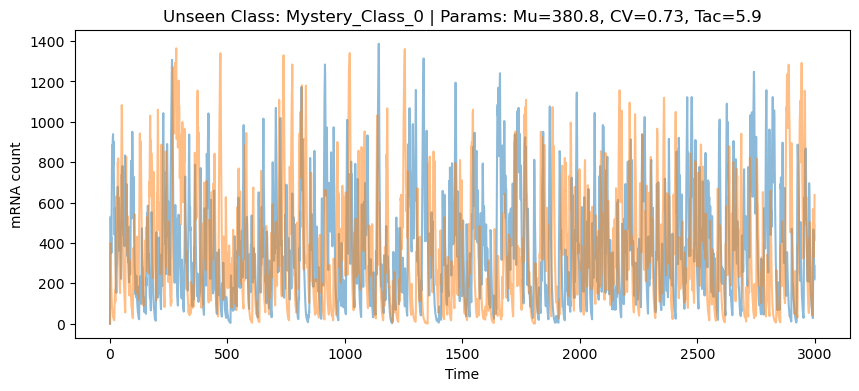

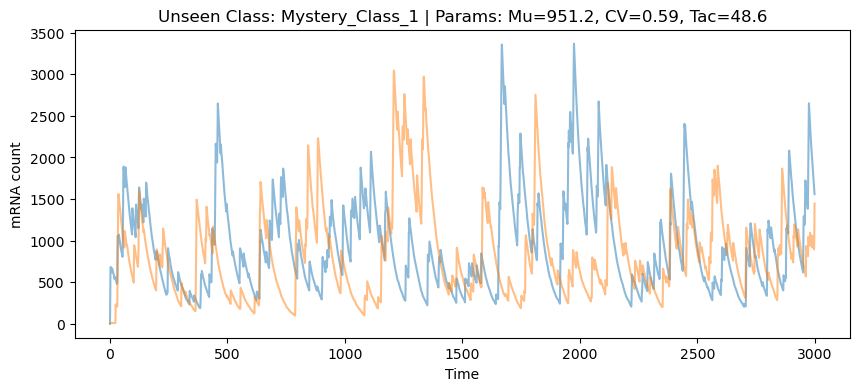

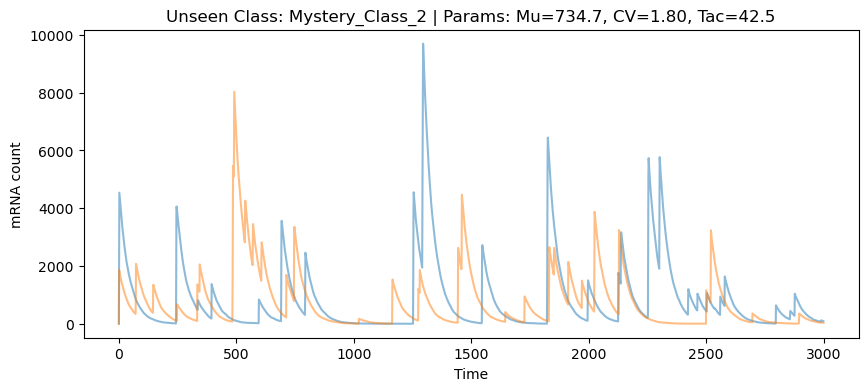

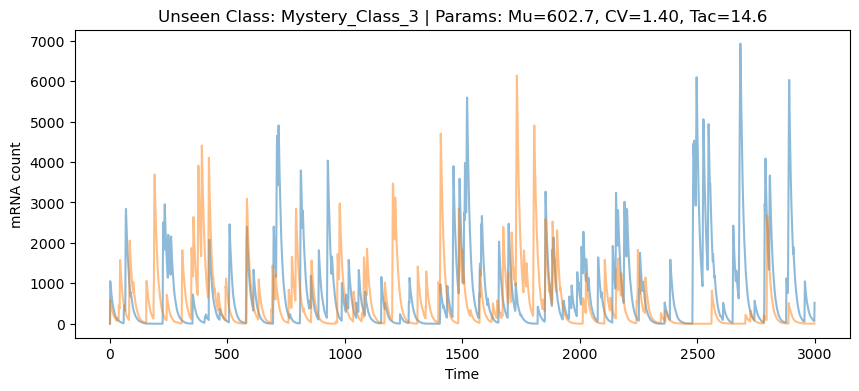

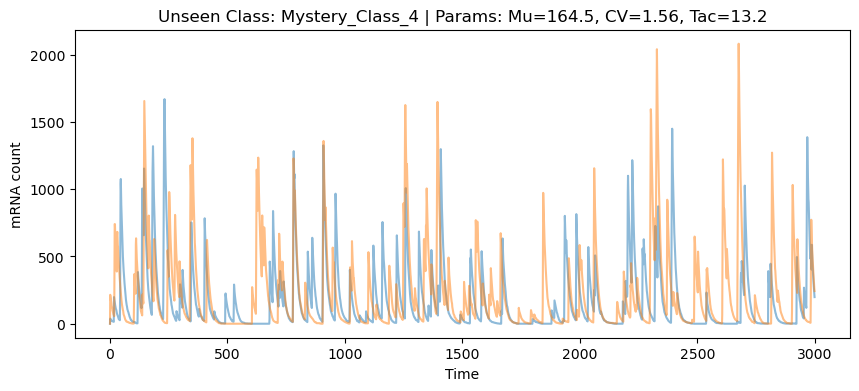

In [27]:
# visualise the unseen classes
for unseen in unseen_datasets:
    trajs = unseen['trajectories']
    plt.figure(figsize=(10,4))
    for i in range(trajs.shape[0]//10):
        plt.plot(trajs[i,:], alpha=0.5)
    plt.title(f"Unseen Class: {unseen['class_id']} | Params: Mu={unseen['parameters']['mu']:.1f}, CV={unseen['parameters']['cv']:.2f}, Tac={unseen['parameters']['tac']:.1f}")
    plt.xlabel("Time")
    plt.ylabel("mRNA count")
    plt.show() 

In [20]:
def build_reference_library(data_list, scaler, crop_len=200, device='cpu', n_shots=5):
    """
    Converts raw data into a clean Reference Library (Tensors).
    Handles NaNs, Infs, and negative values automatically.
    """
    reference_library = {}
    print(f"Building Reference Library ({n_shots}-shot) on {device}...")
    
    for data in data_list:
        class_id = data['class_id']
        # Take first N trajectories
        raw_trajs = data['trajectories'][:n_shots] 
        
        # --- Robust Preprocessing ---
        # 1. Sanitize Input: Replace NaNs with 0, Clip negatives to 0 (for log1p)
        raw_trajs = np.nan_to_num(raw_trajs, nan=0.0, posinf=0.0, neginf=0.0)
        raw_trajs = np.maximum(raw_trajs, 0.0) # Ensure non-negative for log
        
        # 2. Log Transform
        log_trajs = np.log1p(raw_trajs)
        
        # 3. Scaling
        N, T = log_trajs.shape
        # Flatten -> Transform -> Reshape back
        # Note: If scaler has 0 variance for some feature, it might produce NaNs. We sanitize again.
        scaled_flat = scaler.transform(log_trajs.reshape(-1, 1))
        scaled_flat = np.nan_to_num(scaled_flat, nan=0.0) # Sanitize scaler output
        scaled_trajs = scaled_flat.reshape(N, T)
        
        # 4. Cropping / Padding
        processed_list = []
        for i in range(N):
            traj = scaled_trajs[i]
            if len(traj) >= crop_len:
                # Take beginning (or center)
                processed_list.append(traj[:crop_len])
            else:
                # Pad with 0
                pad_len = crop_len - len(traj)
                processed_list.append(np.pad(traj, (0, pad_len), mode='constant', constant_values=0))
                
        # 5. Convert to Tensor & Move to Device
        # Shape: (n_shots, crop_len, 1)
        tensor_stack = torch.tensor(np.array(processed_list), dtype=torch.float32).unsqueeze(-1).to(device)
        reference_library[class_id] = tensor_stack
        
    print(f"✅ Library built for {len(reference_library)} classes.")
    return reference_library

To feed single trajectories into your Siamese model and get a prediction (Class Label), you cannot use the full Siamese architecture (which expects pairs). Instead, you use the Backbone as a feature extractor and a simple Nearest Neighbor (or SVM) Classifier to make the final prediction.

In [21]:
from sklearn.neighbors import KNeighborsClassifier
def setup_inference_engine(model, reference_library, device='cpu'):
    """
    Consumes a Reference Library (Dict of Tensors) and builds the KNN classifier.
    """
    model.eval()
    backbone = model.backbone
    
    ref_features = []
    ref_labels = []
    
    print("Extracting features for Inference Index...")
    
    with torch.no_grad():
        for class_id, ref_tensor in reference_library.items():
            # ref_tensor is already on device and scaled
            
            # 1. Extract Features: (Batch, Time, D) -> (Batch, D)
            embeddings = backbone.encode(ref_tensor).mean(dim=1).cpu().numpy()
            
            # 2. Sanitize Embeddings (Critical check)
            if np.isnan(embeddings).any():
                print(f"⚠️ Warning: NaNs detected in embeddings for class {class_id}. Replacing with 0.")
                embeddings = np.nan_to_num(embeddings, nan=0.0)
            
            # 3. Store
            for emb in embeddings:
                ref_features.append(emb)
                ref_labels.append(class_id)

    # 4. Stack and Shape Check
    X_ref = np.stack(ref_features)
    if X_ref.ndim == 1:
        X_ref = X_ref.reshape(-1, 1)
        
    # 5. Fit KNN
    knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
    knn.fit(X_ref, np.array(ref_labels))
    
    print(f"✅ Inference Engine Ready. Indexed {len(ref_labels)} samples. Feature Dim: {X_ref.shape[1]}")
    return knn, backbone

In [22]:
def predict_single_trajectory(raw_trajectory, feature_extractor, knn, scaler, crop_len=200, device='cpu'):
    """
    Classifies a SINGLE unknown trajectory with NaN protection.
    """
    # 1. Sanitize Input
    # Handle NaNs/Infs in raw data
    clean_traj = np.nan_to_num(raw_trajectory, nan=0.0, posinf=0.0, neginf=0.0)
    clean_traj = np.maximum(clean_traj, 0.0) # Clip negatives
    
    # 2. Log Transform
    traj_log = np.log1p(clean_traj)
    
    # 3. Handle Length (Crop or Pad)
    if len(traj_log) > crop_len:
        start = (len(traj_log) - crop_len) // 2
        traj_crop = traj_log[start : start + crop_len]
    else:
        pad = crop_len - len(traj_log)
        traj_crop = np.pad(traj_log, (0, pad), mode='constant', constant_values=0)
        
    # 4. Scale
    # Reshape for scaler: (1, 1) if single point, or (N, 1)
    traj_scaled = scaler.transform(traj_crop.reshape(-1, 1)).reshape(crop_len)
    traj_scaled = np.nan_to_num(traj_scaled, nan=0.0) # Sanitize scaler output
    
    # 5. To Tensor
    tensor = torch.tensor(traj_scaled, dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)
    
    # 6. Extract Feature
    with torch.no_grad():
        embedding = feature_extractor.encode(tensor).mean(dim=1).cpu().numpy()
        
    # 7. Sanitize Embedding
    embedding = np.nan_to_num(embedding, nan=0.0)
    
    # Ensure 2D shape for KNN
    if embedding.ndim == 1:
        embedding = embedding.reshape(1, -1)
        
    # 8. Predict
    predicted_class = knn.predict(embedding)[0]
    return predicted_class

In [49]:
# 1. Build the Library (Sanitizes data -> Tensors)
ref_lib = build_reference_library(unseen_datasets, scaler, crop_len=200, device=device)

# 2. Setup Engine (Extracts features -> Fits KNN)
inference_knn, backbone = setup_inference_engine(model, ref_lib, device=device)

# 3. Predict (Sanitizes query -> Predicts)
mystery_traj = unseen_datasets[2]['trajectories'][12] # Example query
print(f"True class: {unseen_datasets[2]['class_id']}")
pred = predict_single_trajectory(mystery_traj, backbone, inference_knn, scaler, device=device)
print(f"Prediction: {pred}")

Building Reference Library (5-shot) on cuda:0...
✅ Library built for 5 classes.
Extracting features for Inference Index...
✅ Inference Engine Ready. Indexed 25 samples. Feature Dim: 1
True class: Mystery_Class_2
Prediction: Mystery_Class_2


In [4]:
def test_siamese_performance(model, unseen_data, scaler, crop_len=200):
    model.eval()
    # Detect model device (cpu or cuda) automatically
    device = next(model.parameters()).device
    
    correct = 0
    trials = 0
    
    print(f"\n=== Testing Siamese Model (One-Shot) on {device} ===")
    
    # Create Reference Library (First 5 trajectories of each class)
    reference_library = {}
    for data in unseen_data:
        # Preprocess Reference: Log -> Scale -> Crop
        raw = data['trajectories'][:5] 
        
        # Preprocessing Chain
        log_raw = np.log1p(raw)
        N, T = log_raw.shape
        scaled = scaler.transform(log_raw.reshape(-1, 1)).reshape(N, T)
        
        # Store as tensor on the correct DEVICE
        # We unsqueeze last dim to match model input (N, T, 1)
        reference_library[data['class_id']] = torch.tensor(
            scaled[:, :crop_len], dtype=torch.float32
        ).unsqueeze(-1).to(device)  # <--- MOVED TO DEVICE

    # Run Trials on the REMAINING trajectories (Queries)
    for data in unseen_data:
        true_class = data['class_id']
        queries = data['trajectories'][5:] 
        
        for query_raw in queries:
            # 1. Prepare Query
            start = np.random.randint(0, query_raw.shape[0] - crop_len)
            query_crop = query_raw[start : start+crop_len]
            
            # Log + Scale
            query_log = np.log1p(query_crop)
            query_scaled = scaler.transform(query_log.reshape(-1, 1)).reshape(crop_len)
            
            # Make tensor and move to DEVICE
            query_tensor = torch.tensor(
                query_scaled, dtype=torch.float32
            ).unsqueeze(-1).unsqueeze(0).to(device) # <--- MOVED TO DEVICE
            
            # 2. Compare against ALL References
            scores = {}
            for ref_class, ref_set in reference_library.items():
                class_scores = []
                with torch.no_grad():
                    for ref_sample in ref_set:
                        # ref_sample is already on device from library creation
                        ref_input = ref_sample.unsqueeze(0) 
                        
                        logits = model(query_tensor, ref_input)
                        prob = torch.sigmoid(logits).item()
                        class_scores.append(prob)
                
                scores[ref_class] = np.mean(class_scores)
            
            # 3. Verdict
            predicted_class = max(scores, key=scores.get)
            
            if predicted_class == true_class:
                correct += 1
            trials += 1
            
    acc = correct / trials
    print(f"Siamese Accuracy on Unseen Data: {acc:.2%}")
    return acc

In [13]:
acc = test_siamese_performance(model, unseen_datasets, scaler)


=== Testing Siamese Model (One-Shot) on cuda:0 ===
Siamese Accuracy on Unseen Data: 68.00%


## SVM Model Benchmark


In [ ]:
import numpy as np
import torch
# === 4. SVM Benchmark (Same Hyperparams) ===
def prepare_svm_data(loader):
    """
    Extracts paired data from the Siamese loader and prepares it for SVM.
    Features = [Flattened_x1, Flattened_x2, Flattened_AbsDiff]
    """
    X_list = []
    y_list = []
    
    print(f"Extracting and flattening pairs from loader for SVM...")
    
    # Iterate through the existing loader (which already handles cropping & log-scaling)
    for x1, x2, y in loader:
        # Move to CPU numpy
        x1 = x1.numpy()
        x2 = x2.numpy()
        y_batch = y.numpy().flatten()
        
        # Flatten time dimension: (Batch, Seq_Len, 1) -> (Batch, Seq_Len)
        x1_flat = x1.reshape(x1.shape[0], -1)
        x2_flat = x2.reshape(x2.shape[0], -1)
        
        # Feature Engineering: Explicitly add the difference (Critical for Siamese tasks)
        # Input vector becomes: [Sequence A ... Sequence B ... |A-B| ... ]
        diff_flat = np.abs(x1_flat - x2_flat)
        
        # Concatenate features
        features = np.concatenate([x1_flat, x2_flat, diff_flat], axis=1)
        
        X_list.append(features)
        y_list.append(y_batch)
        
    return np.vstack(X_list), np.concatenate(y_list)

# --- Define the missing variables ---
X_train_svm, y_train = prepare_svm_data(train_loader)
X_test_svm, y_test = prepare_svm_data(test_loader)

print(f"SVM Train Input Shape: {X_train_svm.shape}")
print(f"SVM Test Input Shape:  {X_test_svm.shape}")

# Now call your modular function
from classifiers.svm_classifier import svm_classifier

svm_accuracy = svm_classifier(
    X_train_svm,
    X_test_svm,
    y_train,
    y_test,
)

Extracting and flattening pairs from loader for SVM...


Extracting and flattening pairs from loader for SVM...
SVM Train Input Shape: (20000, 600)
SVM Test Input Shape:  (2000, 600)
=== SVM (RBF Kernel) Classification Accuracy: 0.62 ===
